<a href="https://colab.research.google.com/github/pscabral/IFMASOFTEX_1/blob/main/MobileNet01_teste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gdown
import gdown

# Especifique o ID do arquivo e o nome do arquivo de saída
file_id = '1w8t2KfUsLcNcMBlY8l4hZChZCBf4WYRr'
output = 'VegetableImageDataset.zip'

# Baixe o arquivo do Google Drive
gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)

In [ ]:
!unzip VegetableImageDataset.zip

In [1]:
import os
import PIL
import glob
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns

import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from keras.models import load_model
from tensorflow.random import set_seed

In [2]:
train_path = '../content/Vegetable Images/train'
val_path = '../content/Vegetable Images/validation'
test_path = '../content/Vegetable Images/test'

In [3]:
data_dicts = {
    'train':[],
    'test':[],
    'val':[]
}
data_labels = {
    'train':[],
    'test':[],
    'val':[]
}

In [ ]:
for phase in ['train','val','test']:
    if phase == 'train':
        data_dir = train_path
    elif phase == 'val':
        data_dir = val_path
    else:
        data_dir = test_path
    class_names = sorted(x for x in os.listdir(data_dir)
                            if os.path.isdir(os.path.join(data_dir, x)))
    num_class = len(class_names)
    image_files = [
        [
            os.path.join(data_dir, class_names[i], x)
            for x in os.listdir(os.path.join(data_dir, class_names[i]))
        ]
        for i in range(num_class)
    ]
    num_each = [len(image_files[i]) for i in range(num_class)]
    image_files_list = []
    image_class = []
    for i in range(num_class):
        image_files_list.extend(image_files[i])
        image_class.extend([i] * num_each[i])
    data_dicts[phase] = image_files_list
    data_labels[phase] = image_class
    num_total = len(image_class)
    image_width, image_height = PIL.Image.open(image_files_list[0]).size
    print(f"{phase} information")
    print(f"Image dimensions: {image_width} x {image_height}")
    print(f"Label names: {class_names}")
    print(f"Label counts: {num_each}")
    print(f"Total image count: {num_total}")
    print('--'*8)

In [ ]:
df = pd.DataFrame({'path': data_dicts['train'],'label': data_labels['train']})
sorted_counts  = df.value_counts('label')
fig = px.pie(names=class_names, values=sorted_counts, title="Class Distribution in Trainset", hole=0.3)
fig.show()

In [ ]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(data_dicts['train'][k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [7]:
batch_size = 32
data_generator = {
    'train':ImageDataGenerator(rescale=1/255.,width_shift_range=0.1,
                               height_shift_range=0.1,horizontal_flip=True,rotation_range=10),
    'val':ImageDataGenerator(rescale=1/255.,width_shift_range=0.1,
                               height_shift_range=0.1),
    'test':ImageDataGenerator(rescale=1/255.),
}

In [ ]:
data_sets = {
    'train':data_generator['train'].flow_from_directory(train_path,shuffle=True,class_mode='binary' ,batch_size=batch_size),
    'val':data_generator['val'].flow_from_directory(val_path,shuffle=False,class_mode='binary',batch_size=batch_size),
    'test':data_generator['test'].flow_from_directory(test_path,shuffle=False,class_mode='binary',batch_size=batch_size)
}

In [ ]:
for i,(images,labels) in enumerate(data_sets['train']):
    print('labels of first batch in trainset:',labels)
    print(labels.shape)
    print(images.shape)
    break

In [10]:
def show_images(GRID=[3,3], model=None, size=(8,8), data=data_sets['train']):
    n_rows = GRID[0]
    n_cols = GRID[1]
    n_images = n_cols * n_rows

    i = 1
    plt.figure(figsize=size)
    for images, labels in data:
        id = np.random.randint(32)
        image, label = images[id], class_names[int(labels[id])]

        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)

        if model is None:
            title = f"Class : {label}"
        else:
            pred = class_names[int(np.argmax(model.predict(image[np.newaxis, ...])))]
            title = f"Org : {label}, Pred : {pred}"

        plt.title(title)
        plt.axis('off')

        i+=1
        if i>=(n_images+1):
            break

    plt.tight_layout()
    plt.show()

In [ ]:
show_images()

In [ ]:
pretrained = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=[256,256,3], include_top=False,
    classifier_activation='softmax',
)
pretrained.trainable = False
model = tf.keras.models.Sequential([
    pretrained,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(15, activation='softmax')
])

In [ ]:
model.summary()

In [14]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("final_model.h5", save_best_only=True)
early_stopping_callback = tf.keras.callbacks.EarlyStopping( monitor="val_loss",patience=5, restore_best_weights=True)

In [15]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
epochs = 10
history = model.fit(data_sets['train'], validation_data=data_sets['val'],
                             epochs=epochs,callbacks=[checkpoint_callback,early_stopping_callback])

Epoch 1/10
469/469 [==============================] - ETA: 0s - loss: 0.1166 - accuracy: 0.9676

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



469/469 [==============================] - 1066s 2s/step - loss: 0.1166 - accuracy: 0.9676 - val_loss: 0.0357 - val_accuracy: 0.9893
Epoch 2/10
469/469 [==============================] - 1059s 2s/step - loss: 0.0280 - accuracy: 0.9913 - val_loss: 0.0407 - val_accuracy: 0.9863
Epoch 3/10
469/469 [==============================] - 1056s 2s/step - loss: 0.0207 - accuracy: 0.9933 - val_loss: 0.0130 - val_accuracy: 0.9970
Epoch 4/10
469/469 [==============================] - 1061s 2s/step - loss: 0.0143 - accuracy: 0.9950 - val_loss: 0.0514 - val_accuracy: 0.9813
Epoch 5/10
469/469 [==============================] - 1079s 2s/step - loss: 0.0262 - accuracy: 0.9920 - val_loss: 0.0345 - val_accuracy: 0.9910
Epoch 6/10
469/469 [==============================] - 1077s 2s/step - loss: 0.0136 - accuracy: 0.9959 - val_loss: 0.0115 - val_accuracy: 0.9970
Epoch 7/10
469/469 [==============================] - 1045s 2s/step - loss: 0.0105 - accuracy: 0.9962 - val_loss: 0.0312 - val_accuracy: 0.9923
Epo

In [16]:
history_df = pd.DataFrame(history.history)

In [17]:
history_df

,loss,accuracy,val_loss,val_accuracy
0,0.116616,0.967600,0.035679,0.989333
1,0.027984,0.991267,0.040678,0.986333
2,0.020694,0.993267,0.013026,0.997000
3,0.014311,0.995000,0.051425,0.981333
4,0.026222,0.992000,0.034465,0.991000
5,0.013588,0.995933,0.011492,0.997000
6,0.010494,0.996200,0.031237,0.992333
7,0.017446,0.995267,0.038928,0.991000
8,0.010928,0.997533,0.039443,0.991000
9,0.013462,0.995733,0.049123,0.989667


In [18]:
line = px.line(data_frame= history_df ,y =["accuracy","val_accuracy"] , markers = True)
line.update_xaxes(title="epochs",
              rangeslider_visible = False)
line.update_yaxes(title = "Accuracy")
line.update_layout(showlegend = True,
    title = {
        'text': 'train acc Vs. val acc',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
line.show()

In [19]:
line = px.line(data_frame= history_df ,y =["loss" , "val_loss"] , markers = True)
line.update_xaxes(title="epochs",
              rangeslider_visible = False)
line.update_yaxes(title = "Loss")
line.update_layout(showlegend = True,
    title = {
        'text': 'train loss Vs. val loss',
        'y':0.94,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
line.show()

In [20]:
model.save('mobileNet.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [21]:
model_path = './mobileNet.h5'
model = load_model(model_path)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dense_2 (Dense)             (None, 15)                975       
                                                                 
Total params: 2947663 (11.24 MB)
Trainable params: 68967

In [22]:
score = model.evaluate(data_sets['test'])

94/94 [==============================] - 139s 1s/step - loss: 0.0283 - accuracy: 0.9943


In [23]:
print('{}:{}'.format(model.metrics_names[1],score[1]*100))
print('{}:{}'.format(model.metrics_names[0],score[0]))

accuracy:99.43333268165588
loss:0.02832770347595215


1/1 [==============================] - 0s 57ms/step


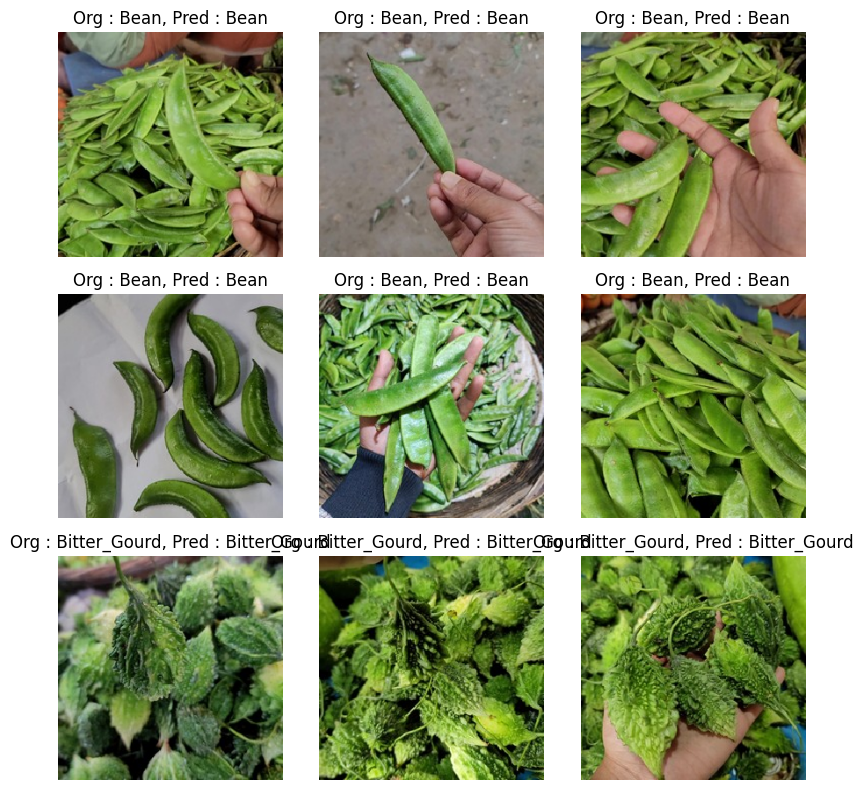

In [24]:
show_images(model=model, data=data_sets['test'])

In [26]:
from sklearn.metrics import classification_report
import numpy as np

# Rótulos reais e rótulos previstos (substitua pelos seus dados reais e previstos)
label_names = ['Bean', 'Bitter_Gourd', 'Bottle_Gourd', 'Brinjal', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Radish', 'Tomato']

# Rótulos reais da primeira batch
actual_labels = [label_names[int(label)] for label in [5, 8, 10, 14, 14, 10, 13, 10, 6, 10, 4, 10, 2, 7, 2, 6, 10, 12, 5, 14, 11, 4, 2, 3, 1, 7, 12, 7, 4, 8, 12, 14]]

# Rótulos previstos (substitua pelos seus rótulos previstos)
predicted_labels = [label_names[int(label)] for label in [5, 8, 10, 14, 14, 10, 13, 10, 6, 10, 4, 10, 2, 7, 2, 6, 10, 12, 5, 14, 11, 4, 2, 3, 1, 7, 12, 7, 4, 8, 12, 14]]

# Gere o relatório de classificação
report = classification_report(actual_labels, predicted_labels)

# Imprima o relatório
print(report)


              precision    recall  f1-score   support

Bitter_Gourd       1.00      1.00      1.00         1
Bottle_Gourd       1.00      1.00      1.00         3
     Brinjal       1.00      1.00      1.00         1
    Broccoli       1.00      1.00      1.00         3
     Cabbage       1.00      1.00      1.00         2
    Capsicum       1.00      1.00      1.00         2
      Carrot       1.00      1.00      1.00         3
 Cauliflower       1.00      1.00      1.00         2
      Papaya       1.00      1.00      1.00         6
      Potato       1.00      1.00      1.00         1
     Pumpkin       1.00      1.00      1.00         3
      Radish       1.00      1.00      1.00         1
      Tomato       1.00      1.00      1.00         4

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



In [28]:
classes = list(data_sets['test'].class_indices.keys())
real_classes = [classes[x] for x in data_sets['test'].labels]

pred = tf.argmax(model.predict(data_sets['test']),axis=1)
pred_classes = [classes[x] for x in pred]

94/94 [==============================] - 143s 2s/step


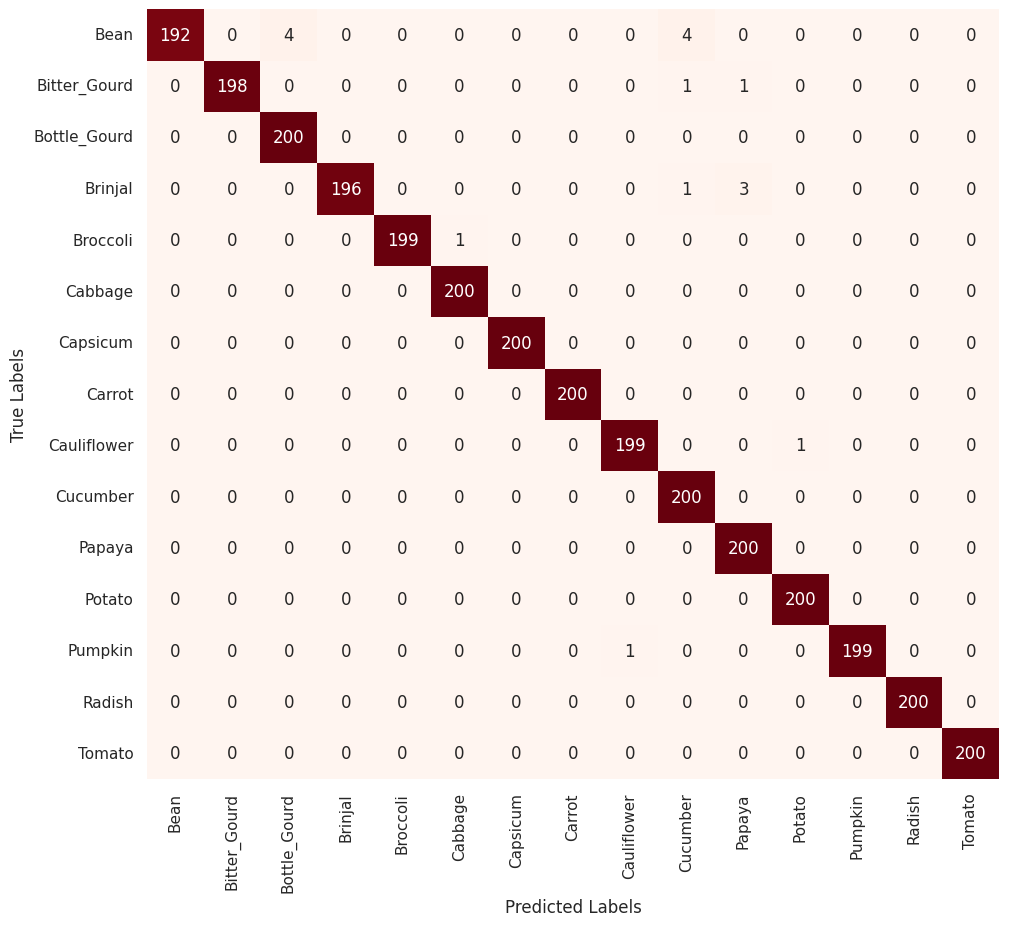

In [29]:
cf_matrix = metrics.confusion_matrix(real_classes,pred_classes)
sns.set_theme(rc={'figure.figsize':(11,10)})
ax = sns.heatmap(cf_matrix,annot=True,cmap='Reds',fmt="g",xticklabels=classes,yticklabels=classes,cbar=False)
ax.set_ylabel('True Labels')
ax.set_xlabel('Predicted Labels');

In [30]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    confusion_matrix = confusion_matrix.astype(int)

    layout = {
        "title": "Confusion Matrix",
        "xaxis": {"title": "Predicted value"},
        "yaxis": {"title": "Real value"}
    }

    fig = go.Figure(data=go.Heatmap(z=confusion_matrix,
                                    x=class_names,
                                    y=class_names,
                                    hoverongaps=False,
                                   ),
                    layout=layout)
    fig.show()

In [31]:
plot_confusion_matrix(real_classes,pred_classes,classes)